In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
import os
import copy
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.datasets import make_classification

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import FastICA, PCA
from sklearn.random_projection import SparseRandomProjection
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.metrics.cluster import adjusted_mutual_info_score, mutual_info_score, normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score


from time import perf_counter

import umap

from utilities import get_reconstruction_error, get_pca_components_for_var, cluster_acc

In [33]:
# Import shared settings
from settings import random_state, n_jobs, nSamples, max_iter, test_size, class_sep
# Override settings
#...

In [34]:
# Used for plot names
dim_red_name = "clustering"
casename = f"synthetic_{dim_red_name}"
# scoreText = "Score (Classification Accuracy)"

# Generate data

In [35]:
X_full, y_full = make_classification(n_samples=nSamples, n_features=40, n_informative=10, n_redundant=5, n_classes=6, random_state=random_state, class_sep=class_sep)

X, X_test, y, y_test = train_test_split(X_full, y_full, test_size=test_size, 
                                      random_state=random_state, stratify=y_full)

print('')
print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')
print("Fraction of training data for each label = ")
for label in np.unique(y):
    print(f'\tData labelled {label} = {(y == label).sum() / float(len(y))}')

print('')
print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')
print("Fraction of testing data for each label = ")
for label in np.unique(y):
    print(f'\tData labelled {label} = {(y == label).sum() / float(len(y))}')


X.shape = (2000, 40)
y.shape = (2000,)
Fraction of training data for each label = 
	Data labelled 0 = 0.165
	Data labelled 1 = 0.169
	Data labelled 2 = 0.17
	Data labelled 3 = 0.1635
	Data labelled 4 = 0.166
	Data labelled 5 = 0.1665

X_test.shape = (500, 40)
y_test.shape = (500,)
Fraction of testing data for each label = 
	Data labelled 0 = 0.165
	Data labelled 1 = 0.169
	Data labelled 2 = 0.17
	Data labelled 3 = 0.1635
	Data labelled 4 = 0.166
	Data labelled 5 = 0.1665


# Apply Clustering

In [36]:
class gmm_wrapper(GaussianMixture):
    def transform(self,X):
        return self.predict_proba(X)

In [37]:
n_components = 20
drs = {
    'No DR': None,
    'PCA': PCA(n_components=n_components, random_state=random_state),
    'ICA': FastICA(n_components=n_components, random_state=random_state, max_iter=max_iter),
    'RP': SparseRandomProjection(n_components=n_components, random_state=random_state),
    'UMAP': umap.UMAP(n_components=n_components, random_state=random_state),
}

hidden_layer_sizes = [(2, ), (6, ), (10, ), (15,)]

results = []

# clusterers = ['gmm']

# n_clusterss = [2]

clusterers = ['km', 'gmm']

n_clusterss = [2, 3, 4, 5, 7, 10, 13, 16, 20, 25, 30]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_test = scaler.transform(X_test)

for dr_name, dr in drs.items():
    if dr is None:
        X_reduced = X.copy()
        X_reduced_test = X_test.copy()
    else:
        X_reduced = dr.fit_transform(X_scaled)
        X_reduced_test = dr.transform(X_scaled_test)

    for name in clusterers:
        for n_clusters in n_clusterss:
            print(f"{dr_name} {name} n_clust={n_clusters}", end='')

            results.append({})
            results[-1]['dr'] = dr_name
            results[-1]['clusterer'] = name
            results[-1]['n_clusters'] = n_clusters
#             results[-1]['dr_obj'] = dr
            
            # Prepare clusterer and predict labels
            if name == 'km':
                clusterer = KMeans(n_clusters, random_state=random_state)
            elif name == 'gmm':
                clusterer = gmm_wrapper(n_clusters, random_state=random_state)
            else:
                raise Exception(".")
            clusterer.fit(X_reduced)
            
            X_clustered = clusterer.transform(X_reduced)
            X_test_clustered = clusterer.transform(X_reduced_test)
            y_pred = clusterer.predict(X_reduced)
            y_test_pred = clusterer.predict(X_reduced_test)

            # Store clustering results
            results[-1]['y_pred'] = y_pred
            results[-1]['y_test_pred'] = y_test_pred
#             results[-1]['cluster_obj'] = clusterer
                        
            # Compute internal metrics
            results[-1]['accuracy'] = cluster_acc(y, y_pred)
            results[-1]['accuracy_test'] = cluster_acc(y_test, y_test_pred)
            results[-1]['score'] = clusterer.score(X_reduced)
            results[-1]['score_test'] = clusterer.score(X_reduced_test)
            results[-1]['silhouette'] = silhouette_score(X_reduced, results[-1]['y_pred'])
            results[-1]['silhouette_test'] = silhouette_score(X_reduced_test, results[-1]['y_test_pred'])
            results[-1]['mutual_info'] = mutual_info_score(y, results[-1]['y_pred'])
            results[-1]['mutual_info_test'] = mutual_info_score(y_test, results[-1]['y_test_pred'])
            results[-1]['normalized_mutual_info'] = normalized_mutual_info_score(y, results[-1]['y_pred'], average_method='arithmetic')
            results[-1]['normalized_mutual_info_test'] = normalized_mutual_info_score(y_test, results[-1]['y_test_pred'], average_method='arithmetic')
            results[-1]['adjusted_rand'] = adjusted_rand_score(y, results[-1]['y_pred'])
            results[-1]['adjusted_rand_test'] = adjusted_rand_score(y_test, results[-1]['y_test_pred'])
            
            print(f" (test) acc={results[-1]['accuracy_test']:.2f}, sil={results[-1]['silhouette_test']:.3f}, nmi={results[-1]['normalized_mutual_info_test']:.3f}", end='')

            # Compute MLP
            param_grid = {'hidden_layer_sizes': hidden_layer_sizes}
            gs = GridSearchCV(MLPClassifier(max_iter=max_iter, random_state=random_state),
                             param_grid=param_grid, verbose=0, cv=3, return_train_score=True,
                             n_jobs=n_jobs)
            gs.fit(X_clustered, y)
            results[-1]['gs_object'] = gs
            results[-1]['mlp_cv_score'] = gs.best_score_
            results[-1]['mlp_test_score'] = gs.score(X_test_clustered, y_test)
                  
            print(f", mlp_cv={results[-1]['mlp_cv_score']}")
        # Save results along the way
        joblib.dump(results, f"{casename}_gs_results_intermediate.pkl")
                  

No DR km n_clust=2 (test) acc=0.32, sil=0.156, nmi=0.187, mlp_cv=0.352
No DR km n_clust=3 (test) acc=0.37, sil=0.161, nmi=0.255, mlp_cv=0.4745
No DR km n_clust=4 (test) acc=0.47, sil=0.161, nmi=0.329, mlp_cv=0.543
No DR km n_clust=5 (test) acc=0.45, sil=0.144, nmi=0.323, mlp_cv=0.619
No DR km n_clust=7 (test) acc=0.52, sil=0.138, nmi=0.362, mlp_cv=0.6905
No DR km n_clust=10 (test) acc=0.65, sil=0.127, nmi=0.445, mlp_cv=0.77
No DR km n_clust=13 (test) acc=0.67, sil=0.114, nmi=0.433, mlp_cv=0.794
No DR km n_clust=16 (test) acc=0.69, sil=0.113, nmi=0.430, mlp_cv=0.78
No DR km n_clust=20 (test) acc=0.71, sil=0.094, nmi=0.442, mlp_cv=0.8
No DR km n_clust=25 (test) acc=0.73, sil=0.091, nmi=0.451, mlp_cv=0.788
No DR km n_clust=30 (test) acc=0.77, sil=0.079, nmi=0.463, mlp_cv=0.7915
No DR gmm n_clust=2 (test) acc=0.32, sil=0.127, nmi=0.260, mlp_cv=0.344
No DR gmm n_clust=3 (test) acc=0.41, sil=0.133, nmi=0.336, mlp_cv=0.435
No DR gmm n_clust=4 (test) acc=0.49, sil=0.128, nmi=0.407, mlp_cv=0.51

C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


, mlp_cv=0.709
PCA gmm n_clust=16 (test) acc=0.71, sil=0.006, nmi=0.457, mlp_cv=0.7295
PCA gmm n_clust=20 (test) acc=0.68, sil=-0.044, nmi=0.413, mlp_cv=0.706
PCA gmm n_clust=25 (test) acc=0.67, sil=-0.024, nmi=0.386, mlp_cv=0.7085
PCA gmm n_clust=30 (test) acc=0.67, sil=-0.043, nmi=0.370, mlp_cv=0.671


C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


ICA km n_clust=2 (test) acc=0.32, sil=0.038, nmi=0.228, mlp_cv=0.1685
ICA km n_clust=3 (test) acc=0.46, sil=0.044, nmi=0.363, mlp_cv=0.277
ICA km n_clust=4 (test) acc=0.47, sil=0.051, nmi=0.388

C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


, mlp_cv=0.2865
ICA km n_clust=5 (test) acc=0.55, sil=0.045, nmi=0.449

C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


, mlp_cv=0.477
ICA km n_clust=7 (test) acc=0.61, sil=0.052, nmi=0.456, mlp_cv=0.709
ICA km n_clust=10 (test) acc=0.63, sil=0.040, nmi=0.423

C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


, mlp_cv=0.716
ICA km n_clust=13 (test) acc=0.57, sil=0.035, nmi=0.338, mlp_cv=0.7185
ICA km n_clust=16 (test) acc=0.58, sil=0.034, nmi=0.347, mlp_cv=0.7085
ICA km n_clust=20 (test) acc=0.53, sil=0.023, nmi=0.268, mlp_cv=0.705
ICA km n_clust=25 (test) acc=0.57, sil=0.014, nmi=0.296

C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


, mlp_cv=0.712
ICA km n_clust=30 (test) acc=0.56, sil=0.013, nmi=0.282

C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


, mlp_cv=0.709
ICA gmm n_clust=2 (test) acc=0.33, sil=0.038, nmi=0.286, mlp_cv=0.4
ICA gmm n_clust=3 (test) acc=0.47, sil=0.043, nmi=0.405, mlp_cv=0.502
ICA gmm n_clust=4 (test) acc=0.46, sil=0.048, nmi=0.394, mlp_cv=0.508
ICA gmm n_clust=5 (test) acc=0.54, sil=0.040, nmi=0.428, mlp_cv=0.5695
ICA gmm n_clust=7 (test) acc=0.63, sil=0.036, nmi=0.466, mlp_cv=0.674
ICA gmm n_clust=10 (test) acc=0.63, sil=0.023, nmi=0.428, mlp_cv=0.6285
ICA gmm n_clust=13 (test) acc=0.59, sil=-0.017, nmi=0.385, mlp_cv=0.589
ICA gmm n_clust=16 (test) acc=0.62, sil=-0.008, nmi=0.402, mlp_cv=0.6025
ICA gmm n_clust=20 (test) acc=0.60, sil=-0.009, nmi=0.343, mlp_cv=0.599
ICA gmm n_clust=25 (test) acc=0.58, sil=-0.025, nmi=0.323, mlp_cv=0.5715
ICA gmm n_clust=30 (test) acc=0.59, sil=-0.031, nmi=0.330, mlp_cv=0.563
RP km n_clust=2 (test) acc=0.23, sil=0.096, nmi=0.032, mlp_cv=0.2425
RP km n_clust=3 (test) acc=0.29, sil=0.082, nmi=0.103, mlp_cv=0.3125
RP km n_clust=4 (test) acc=0.33, sil=0.071, nmi=0.117, mlp_cv=0.

C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


, mlp_cv=0.516
RP km n_clust=25 (test) acc=0.45, sil=0.034, nmi=0.196, mlp_cv=0.5375
RP km n_clust=30 (test) acc=0.46, sil=0.024, nmi=0.198

C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


, mlp_cv=0.54
RP gmm n_clust=2 (test) acc=0.21, sil=0.061, nmi=0.017, mlp_cv=0.2465
RP gmm n_clust=3 (test) acc=0.37, sil=0.043, nmi=0.220, mlp_cv=0.383
RP gmm n_clust=4 (test) acc=0.38, sil=0.022, nmi=0.211, mlp_cv=0.405
RP gmm n_clust=5 (test) acc=0.35, sil=0.017, nmi=0.184, mlp_cv=0.426
RP gmm n_clust=7 (test) acc=0.45, sil=0.002, nmi=0.241, mlp_cv=0.47
RP gmm n_clust=10 (test) acc=0.44, sil=-0.008, nmi=0.199, mlp_cv=0.449
RP gmm n_clust=13 (test) acc=0.43, sil=-0.027, nmi=0.200, mlp_cv=0.4645
RP gmm n_clust=16 (test) acc=0.43, sil=-0.032, nmi=0.163, mlp_cv=0.4365
RP gmm n_clust=20 (test) acc=0.38, sil=-0.051, nmi=0.140, mlp_cv=0.407
RP gmm n_clust=25 (test) acc=0.41, sil=-0.047, nmi=0.177, mlp_cv=0.4175
RP gmm n_clust=30 (test) acc=0.39, sil=-0.056, nmi=0.144, mlp_cv=0.413
UMAP km n_clust=2 (test) acc=0.33, sil=0.319, nmi=0.342, mlp_cv=0.5915
UMAP km n_clust=3 (test) acc=0.43, sil=0.342, nmi=0.355, mlp_cv=0.6755
UMAP km n_clust=4 (test) acc=0.55, sil=0.337, nmi=0.471, mlp_cv=0.725


C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


, mlp_cv=0.7385
UMAP km n_clust=10 (test) acc=0.67, sil=0.309, nmi=0.477, mlp_cv=0.7565
UMAP km n_clust=13 (test) acc=0.70, sil=0.287, nmi=0.469, mlp_cv=0.7615
UMAP km n_clust=16 (test) acc=0.71, sil=0.262, nmi=0.471, mlp_cv=0.754
UMAP km n_clust=20 (test) acc=0.71, sil=0.230, nmi=0.464, mlp_cv=0.7665
UMAP km n_clust=25 (test) acc=0.71, sil=0.185, nmi=0.456, mlp_cv=0.761
UMAP km n_clust=30 (test) acc=0.72, sil=0.148, nmi=0.442, mlp_cv=0.761
UMAP gmm n_clust=2 (test) acc=0.33, sil=0.311, nmi=0.336, mlp_cv=0.327
UMAP gmm n_clust=3 (test) acc=0.43, sil=0.320, nmi=0.339, mlp_cv=0.4275
UMAP gmm n_clust=4 (test) acc=0.57, sil=0.269, nmi=0.502, mlp_cv=0.5505
UMAP gmm n_clust=5 (test) acc=0.58, sil=0.275, nmi=0.480, mlp_cv=0.5585
UMAP gmm n_clust=7 (test) acc=0.58, sil=0.301, nmi=0.463, mlp_cv=0.5535
UMAP gmm n_clust=10 (test) acc=0.66, sil=0.241, nmi=0.476, mlp_cv=0.683
UMAP gmm n_clust=13 (test) acc=0.67, sil=0.218, nmi=0.450, mlp_cv=0.6915
UMAP gmm n_clust=16 (test) acc=0.67, sil=0.161, nmi

In [38]:
joblib.dump(results, f"{casename}_gs_results.pkl")

['synthetic_clustering_gs_results.pkl']

In [39]:
df = pd.DataFrame(results)
df.to_csv(f"{casename}_gs_results.csv")
# df.loc[df.loc[:, 'clusterer'] == 'km', 'score'] = df.loc[df.loc[:, 'clusterer'] == 'km', 'score'] * -1 

Text(0, 0.5, 'Accuracy')

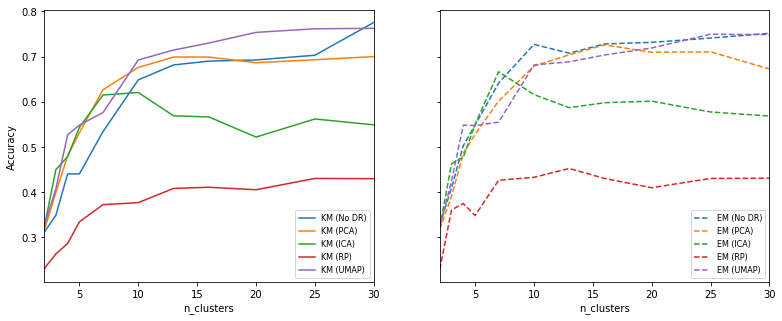

In [81]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(13, 5))

for this_dr in df.loc[:, 'dr'].unique():
    df.loc[(df.loc[:, 'clusterer'] == 'km') & (df.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='accuracy', label=f'KM ({this_dr})', ax=axs[0], ls='-')
    c = axs[0].get_lines()[-1].get_color()
    df.loc[(df.loc[:, 'clusterer'] == 'gmm') & (df.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='accuracy', label=f'EM ({this_dr})', ax=axs[1], ls='--', c=c)
axs[0].legend(fontsize=8)
axs[1].legend(fontsize=8)
axs[0].set_ylabel("Accuracy")

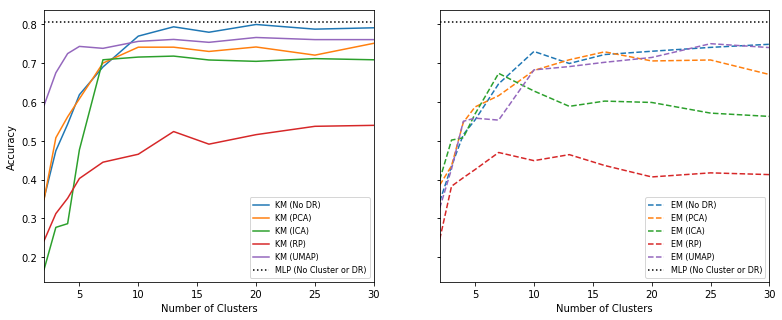

In [84]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(13, 5))

mlp_no_reduction = pd.read_csv(f'synthetic_nn_all_features_results.csv')
axs[0].hlines(mlp_no_reduction.loc[:, 'mean_test_score'].max(), df.n_clusters.min(), df.n_clusters.max(), label='MLP (No Cluster or DR)', linestyle=':')
axs[1].hlines(mlp_no_reduction.loc[:, 'mean_test_score'].max(), df.n_clusters.min(), df.n_clusters.max(), label='MLP (No Cluster or DR)', linestyle=':')

for this_dr in df.loc[:, 'dr'].unique():
    df.loc[(df.loc[:, 'clusterer'] == 'km') & (df.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='mlp_cv_score', label=f'KM ({this_dr})', ax=axs[0], ls='-')
    c = axs[0].get_lines()[-1].get_color()
    df.loc[(df.loc[:, 'clusterer'] == 'gmm') & (df.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='mlp_cv_score', label=f'EM ({this_dr})', ax=axs[1], ls='--', c=c)
axs[0].legend(fontsize=8)
axs[1].legend(fontsize=8)
axs[0].set_xlabel("Number of Clusters")
axs[1].set_xlabel("Number of Clusters")
axs[0].set_ylabel("Accuracy")
fig.savefig(f'{casename}_cluster_accuracy.png')

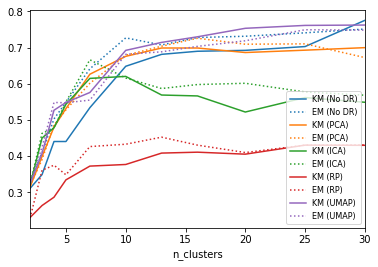

In [41]:
fig, ax = plt.subplots()
# df.loc[df.loc[:, 'clusterer'] == 'km'].plot(x='n_clusters', y='accuracy', label='KM (no DR)', lw=3, ls='-', ax=ax)
# # ax2 = ax.twinx()
# df.loc[df.loc[:, 'clusterer'] == 'gmm'].plot(x='n_clusters', y='accuracy', label='EM (no DR)', lw=3, ls=':', ax=ax, c=c)

for this_dr in df.loc[:, 'dr'].unique():
    
    df.loc[(df.loc[:, 'clusterer'] == 'km') & (df.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='accuracy', label=f'KM ({this_dr})', ax=ax, ls='-')
    c = ax.get_lines()[-1].get_color()
    df.loc[(df.loc[:, 'clusterer'] == 'gmm') & (df.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='accuracy', label=f'EM ({this_dr})', ax=ax, ls=':', c=c)
# ax.set_xlim((0, df.loc[:, 'n_clusters'].max()))
ax.legend(fontsize=8)

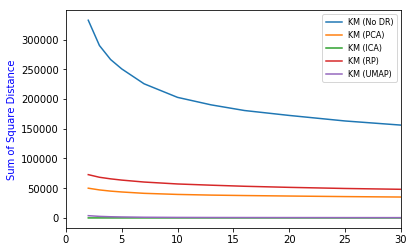

In [42]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Sum of Square Distance")

for this_dr in df.loc[:, 'dr'].unique():
#     if "No DR" in this_dr:
#         continue
    this_x = df.loc[(df.loc[:, 'clusterer'] == 'km') & (df.loc[:, 'dr'] == this_dr), "n_clusters"]
    this_y = -df.loc[(df.loc[:, 'clusterer'] == 'km') & (df.loc[:, 'dr'] == this_dr), "score"]
#     this_y = this_y / this_y.max()
    ax.plot(this_x, this_y, label=f'KM ({this_dr})', ls='-')
ax.set_xlim((0, df.loc[:, 'n_clusters'].max()))
ax.legend(fontsize=8)

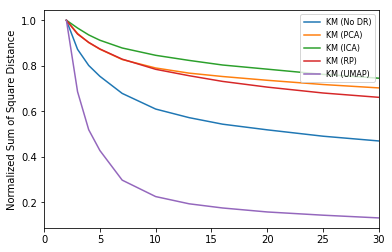

In [82]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Normalized Sum of Square Distance")

for this_dr in df.loc[:, 'dr'].unique():
#     if "No DR" in this_dr:
#         continue
    this_x = df.loc[(df.loc[:, 'clusterer'] == 'km') & (df.loc[:, 'dr'] == this_dr), "n_clusters"]
    this_y = -df.loc[(df.loc[:, 'clusterer'] == 'km') & (df.loc[:, 'dr'] == this_dr), "score"]
    this_y = this_y / this_y.max()
    ax.plot(this_x, this_y, label=f'KM ({this_dr})', ls='-')
ax.set_xlim((0, df.loc[:, 'n_clusters'].max()))
ax.legend(fontsize=8)
fig.savefig(f'{casename}_km_sse.png')

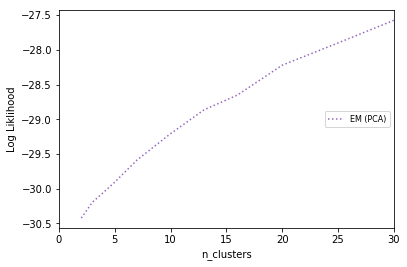

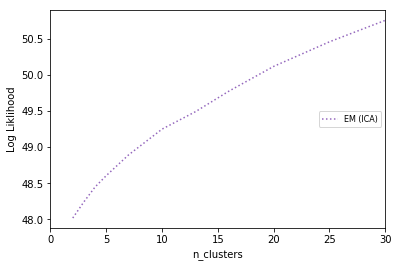

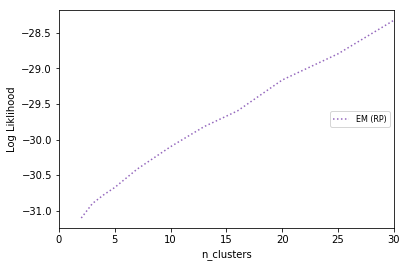

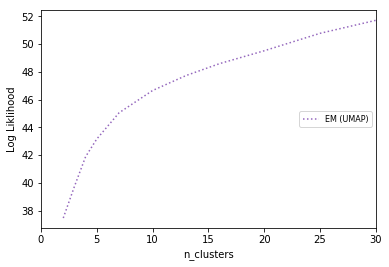

In [45]:
for this_dr in df.loc[:, 'dr'].unique():
    if "No DR" in this_dr:
        continue
    fig, ax = plt.subplots()

    df.loc[(df.loc[:, 'clusterer'] == 'gmm') & (df.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='score', label=f'EM ({this_dr})', ax=ax, ls=':', c=c)

    ax.set_xlim((0, df.loc[:, 'n_clusters'].max()))
    ax.set_ylabel('Log Liklihood')
#     ax.semilogy()
    ax.legend(fontsize=8, loc="right")
    plt.show()


No handles with labels found to put in legend.
C:\Users\Scribs\Anaconda3\lib\site-packages\matplotlib\ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


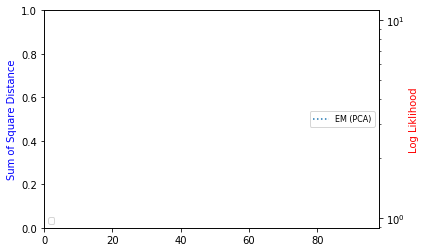

In [23]:
fig, ax = plt.subplots()
# df.loc[df.loc[:, 'clusterer'] == 'km'].plot(x='n_clusters', y='score', label='KM (no DR)', lw=3, ls='-', ax=ax)
# ax2 = ax.twinx()
ax.set_ylabel("Sum of Square Distance", color='b')
ax2 = ax.twinx()
# df.loc[df.loc[:, 'clusterer'] == 'gmm'].plot(x='n_clusters', y='score', label='EM (no DR)', lw=3, ls=':', ax=ax2, c=c)

for this_dr in df.loc[:, 'dr'].unique():
    if "No DR" in this_dr:
        continue
    
#     df.loc[(df.loc[:, 'clusterer'] == 'km') & (df.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='score', label=f'KM ({this_dr})', ax=ax, ls='-')
    c = None#ax.get_lines()[-1].get_color()
    df.loc[(df.loc[:, 'clusterer'] == 'gmm') & (df.loc[:, 'dr'] == this_dr)].plot(x='n_clusters', y='score', label=f'EM ({this_dr})', ax=ax2, ls=':', c=c)
ax.set_xlim((0, df.loc[:, 'n_clusters'].max()))
ax.legend(fontsize=8, loc="lower left")

ax2.set_ylabel('Log Liklihood', color='r')
ax2.semilogy()
ax2.legend(fontsize=8, loc="right")

In [78]:
this_scaler = StandardScaler()
X_scaled_for_vis = this_scaler.fit_transform(X)
km = KMeans(n_clusters=6, random_state=random_state)
km.fit(X_scaled_for_vis)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

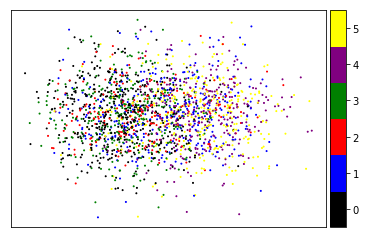

In [79]:
fig, ax = plt.subplots()

# make a color map of fixed colors
cmap = colors.ListedColormap(['black', 'blue', 'red', 'green', 'purple', 'yellow'])
bounds = np.linspace(y.min() - 0.5, y.max() + 0.5, len(np.unique(y)) + 1)
norm = colors.BoundaryNorm(bounds, cmap.N)

# sc = ax.scatter(X_vis[:, 0], X_vis[:, 1], c=y, s=1, cmap=cmap, norm=norm)
sc = ax.scatter(X[:, 0], X[:, 1], c=km.predict(X_scaled_for_vis), s=1, cmap=cmap, norm=norm)
ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax.get_figure().colorbar(sc, cax=cax, ticks=[0, 1, 2, 3, 4, 5])

fig.savefig('synthetic_vis_pca.png')